Проект
# Предсказание вероятности покупки в интернет-магазине

*Цель*
Предсказать вероятность покупки в течение 90 дней

*Задачи:*

●  Изучить данные

● Разработать полезные признаки

● Создать модель для классификации пользователей

● Улучшить модель и максимизировать метрику roc_auc

● Выполнить тестирование

*План проекта*

1. Загрузка данных
   
2. Предобработка данных
   
3. Исследовательский анализ данных
   
4. Проверка на мультиколлинеарность
   
5. Обучение моделей
   
6. Выводы

  
*Описание данных*

`apparel-purchases`

история покупок

● `client_id` идентификатор пользователя

● `quantity` количество товаров в заказе

● `price` цена товара

● `category_ids` вложенные категории, к которым отнсится товар

● `date` дата покупки

● `message_id` идентификатор сообщения из рассылки

`apparel-messages`

история рекламных рассылок

● `bulk_campaign_id` идентификатор рекламной кампании

● `client_id` идентификатор пользователя

● `message_id` идентификатор сообщений

● `event` тип действия

● `channel` канал рассылки

● `date` дата рассылки

● `created_at` точное время создания сообщения

`apparel-target_binary`
совершит ли клиент покупку в течение следующих 90 дней

● `client_id` идентификатор пользователя

● `target` целевой признак

## 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.impute import SimpleImputer



In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
try:
    purchases = pd.read_csv('/Users/evgenia/Downloads/apparel-purchases.csv', parse_dates=['date'])
except:
    purchases = pd.read_csv('/datasets/apparel-purchases.csv', parse_dates=['date'])

In [4]:
def beginning(df):
    print('Обзор данных из файла')
    print('1. Вывод первых строк на экран')
    display(df.head())
    print('---------------------------------------')
    print('2. Проверка типов данных')
    df.info()
    print('---------------------------------------')
    print('3. Проверка явных дубликатов:')
    print(df.duplicated().sum())
    print('---------------------------------------')
    print('4. Проверка пропусков:')
    print()
    frame = ({'nan_qty' : df.isna().sum().sort_values(ascending=False),
         'nan_percent' : round((df.isna().mean()*100).sort_values(ascending=False), 2)})
    nan_df = pd.DataFrame(frame)
    nan_df = nan_df.style.set_properties(**{'background-color': 'skyblue', 'color': 'white'})
    display(nan_df)

In [5]:
beginning(purchases)

Обзор данных из файла
1. Вывод первых строк на экран


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


---------------------------------------
2. Проверка типов данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
---------------------------------------
3. Проверка явных дубликатов:
73020
---------------------------------------
4. Проверка пропусков:



,nan_qty,nan_percent
client_id,0,0.000000
quantity,0,0.000000
price,0,0.000000
category_ids,0,0.000000
date,0,0.000000
message_id,0,0.000000


Мы видим:
* большое количество явных дубликатов (на этапе предобработки примем решение, являются ли они действительно дубликатами),
* тип данных в столбце с датой можно изменить (сделали на этапе загрузки),
* тип данных в категориях - object - возможно, придется поменять (столбец нуждается в предобработке),
* тип сообщения и идентификатор пользователя работают только как ключи - сами по себе не несут информации, которую можно интерпретировать.

In [6]:
try:
    messages = pd.read_csv('/Users/Evgenia/downloads/apparel-messages.csv', parse_dates=['date','created_at'])
except:
        messages = pd.read_csv('/datasets/apparel-messages.csv', parse_dates=['date','created_at'])



In [7]:
beginning(messages)

Обзор данных из файла
1. Вывод первых строк на экран


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


---------------------------------------
2. Проверка типов данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
---------------------------------------
3. Проверка явных дубликатов:
48610
---------------------------------------
4. Проверка пропусков:



,nan_qty,nan_percent
bulk_campaign_id,0,0.000000
client_id,0,0.000000
message_id,0,0.000000
event,0,0.000000
channel,0,0.000000
date,0,0.000000
created_at,0,0.000000


Видим, что:
* в датасете большое количество полных дубликатов (на этапе предобработки предстоит выяснить, можно ли их удалять)
* формат дат заменен на этапе загрузки,
* есть потенциал для создания нового признака на основе дельты дат.

In [8]:
try:
    target = pd.read_csv('/Users/Evgenia/downloads/apparel-target_binary.csv')
except:
    target = pd.read_csv('/datasets/apparel-target_binary.csv')

In [9]:
beginning(target)

Обзор данных из файла
1. Вывод первых строк на экран


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


---------------------------------------
2. Проверка типов данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
---------------------------------------
3. Проверка явных дубликатов:
0
---------------------------------------
4. Проверка пропусков:



,nan_qty,nan_percent
client_id,0,0.000000
target,0,0.000000


Видим отсутствие пропусков и дубликатов в датафрейме. Кроме того, видим, что третий датафрейм с целевым признаком в несколько раз меньше первого датафрейма (purchases) и в сотни раз меньше второго датафрейма (messages), что говорит о необходимости агрегации первых двух датафреймов.

Проведем загрузку дополнительных документов.

In [10]:
try:
    channel = pd.read_csv('/Users/Evgenia/downloads/full_campaign_daily_event_channel.csv')
except:
    channel = pd.read_csv('/datasets/full_campaign_daily_event_channel.csv')

In [11]:
beginning(channel)

Обзор данных из файла
1. Вывод первых строк на экран


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---------------------------------------
2. Проверка типов данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click

,nan_qty,nan_percent
date,0,0.000000
bulk_campaign_id,0,0.000000
count_hard_bounce_mobile_push,0,0.000000
count_send_mobile_push,0,0.000000
nunique_hard_bounce_mobile_push,0,0.000000
nunique_send_mobile_push,0,0.000000
count_hard_bounce_email,0,0.000000
count_hbq_spam_email,0,0.000000
count_send_email,0,0.000000
nunique_hard_bounce_email,0,0.000000


В датафрейме содержится информация о суммарной реакции пользователей на рекламные кампании: позитивной (открыть письмо, купить и т.д.), и негативной (отправить письмо в спам).

Эту информацию потенциально можно использовать, особенно после этапа предобработки и EDA.

In [12]:
try:
    event = pd.read_csv('/Users/Evgenia/downloads/full_campaign_daily_event.csv')
except:
    event = pd.read_csv('/datasets/full_campaign_daily_event.csv')

In [13]:
beginning(event)

Обзор данных из файла
1. Вывод первых строк на экран


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


---------------------------------------
2. Проверка типов данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open       

,nan_qty,nan_percent
date,0,0.000000
bulk_campaign_id,0,0.000000
count_close,0,0.000000
nunique_hbq_spam,0,0.000000
count_hbq_spam,0,0.000000
nunique_unsubscribe,0,0.000000
nunique_subscribe,0,0.000000
nunique_soft_bounce,0,0.000000
nunique_send,0,0.000000
nunique_purchase,0,0.000000


В датафрейме хранится информация о суммарных целевых действиях для каждой компании без конкретизации канала. На дальнейших этапах стоит проверить, насколько отличаются друг от друга таблицы (совпадут ли суммарные показатели по каналам в разных таблицах).

*Промежуточный вывод:*

Мы загрузили три обязательных для работы датафрейма и два дополнительных.

В обязательных для работы датафреймах необходимо решить вопрос дубликатов, агрегировать данные по пользовательским id и решить проблему категоризации товаров.

Набор признаков позволяет создать дополнительные - временную дельту или общую сумму купленных товаров.

В дополнительных материалах можно проверить, совпадают ли данные в таблицах, и впоследствии сделать вывод об эффективности рекламных кампаний разного типа.

Видим, что в двух таблицах есть столбцы разного содержания с одинаковым названием - date (дата покупки и дата рассылки).


## 2. Предобработка данных.

Поскольку в messages содержится полная дата и отметка времени, то можем предположить, что явные дубликаты можно удалить.

In [14]:
messages = messages.drop_duplicates()
len(messages)

12691188

Решение и его аргументация по дубликатам purchases будет дана после объединения таблиц.

In [15]:
len(purchases[~purchases['client_id'].isin(messages['client_id'])])/len(purchases)

0.17740643297990188

In [16]:
len(messages[~messages['client_id'].isin(purchases['client_id'])])/len(messages)

0.14009649845231195

Видим, что не все пользовательские id совпадают в таблицах.

In [17]:
len(target[~target['client_id'].isin(purchases['client_id'])])/len(target)

0.0

In [18]:
len(target[~target['client_id'].isin(messages['client_id'])])/len(target)

0.15781660615057475

In [19]:
len(messages[~messages['client_id'].isin(target['client_id'])])/len(messages)

0.14009649845231195

In [20]:
len(purchases[~purchases['client_id'].isin(target['client_id'])])/len(purchases)

0.0

Видим, что все пользовательские id из таблицы target присутствуют в purchases, но более 15 процентов из них нет в messages.
Проверим, как выглядят несовпадающие строки (вдруг это очень пассивные клиенты, которых не учитывают по этой причине, или нули).

In [21]:
messages[~messages['client_id'].isin(target['client_id'])].head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
34,4439,1515915625482924787,1515915625482924787-4439-6283411e406a4,open,email,2022-05-19,2022-05-19 02:33:01
152,4439,1515915625477101741,1515915625477101741-4439-62834137a8428,open,email,2022-05-19,2022-05-19 05:27:51
153,4439,1515915625477101741,1515915625477101741-4439-62834137a8428,click,email,2022-05-19,2022-05-19 05:28:11
239,4463,1515915625491815518,1515915625491815518-4463-6285e403d8023,send,email,2022-05-19,2022-05-19 06:30:29
243,4463,1515915625551895032,1515915625551895032-4463-6285e403d81e0,send,email,2022-05-19,2022-05-19 06:30:29
246,4463,1515915625475625464,1515915625475625464-4463-6285e403da974,send,email,2022-05-19,2022-05-19 06:30:30
280,4463,1515915625468261908,1515915625468261908-4463-6285e403dd479,send,email,2022-05-19,2022-05-19 06:30:32
301,4463,1515915625484332962,1515915625484332962-4463-6285e403ddd31,send,email,2022-05-19,2022-05-19 06:30:33
310,4463,1515915625489170339,1515915625489170339-4463-6285e403de28b,send,email,2022-05-19,2022-05-19 06:30:33
328,4463,1515915625499413660,1515915625499413660-4463-6285e403df077,send,email,2022-05-19,2022-05-19 06:30:34


In [22]:
target[~target['client_id'].isin(messages['client_id'])].head(10)

,client_id,target
293,1515915625468081882,0
347,1515915625468087979,0
418,1515915625468093885,1
564,1515915625468105189,0
777,1515915625468122963,0
784,1515915625468123423,0
1044,1515915625468144856,0
1185,1515915625468156280,0
1363,1515915625468169394,0
1477,1515915625468178033,0


Закономерности в несовпадающих данных не видим. 

In [23]:
purchases = purchases.rename(columns={'date':'date_p'})

In [24]:
messages = messages.rename(columns={'date':'date_m'})

In [25]:
pm = pd.merge(purchases, messages, how='left', on=['client_id', 'message_id'])

In [26]:
purchases[~purchases['client_id'].isin(pm['client_id'])]

,client_id,quantity,price,category_ids,date_p,message_id


In [27]:
purchases[~purchases['message_id'].isin(pm['message_id'])]

,client_id,quantity,price,category_ids,date_p,message_id


Проверили, что в процессе объединения таблиц все индексы успешно вошли в итоговый датафрейм.

Принимаем решение по дубликатам в purchase: посмотрим после объединения на таблицу (выберем те индексы, по которым есть информация из таблицы messages).

In [28]:
pm[pm['message_id'].isin(messages['message_id'])]

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,4172.0,open,email,2022-05-27,2022-05-27 07:52:08
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090.0,click,email,2023-04-12,2023-04-12 08:25:33
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090.0,click,email,2023-04-18,2023-04-18 11:47:45
13,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090.0,click,email,2023-06-13,2023-06-13 11:10:41
14,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,2090.0,click,email,2023-12-28,2023-12-28 11:25:50
...,...,...,...,...,...,...,...,...,...,...,...
837730,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648.0,open,mobile_push,2024-02-15,2024-02-15 07:08:38
837731,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648.0,click,mobile_push,2024-02-15,2024-02-15 16:23:39
837732,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648.0,send,mobile_push,2024-02-15,2024-02-15 07:08:21
837733,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,14648.0,open,mobile_push,2024-02-15,2024-02-15 07:08:38


Мы видим, что полные дубликаты таблицы purchases (например, с индексами 837730 - 837734) могут иметь разные целевые действия из таблицы messages: где-то пользователь открыл сообщение, где-то кликнул. Точная дата создания сообщения тоже разная. Поэтому мы приняли решение оставить дубликаты в purchases.

Однако после объединения стоит удалить полные дубликаты в таблице pm - мы не нашли причин их оставить.

In [29]:
pm.duplicated().sum()

301789

In [30]:
pm = pm.drop_duplicates()

In [31]:
#присоединяем целевой признак и проверяем, все ли строки вошли
pm = pd.merge(pm, target, how='left', on='client_id')

In [32]:
target[~target['client_id'].isin(pm['client_id'])]

,client_id,target


In [33]:
#попробуем провести векторизацию категорий и выделить на этой основе кластеры
categories = pm['category_ids']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(categories)

In [34]:
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

In [35]:
kmeans.fit(X)

KMeans(n_clusters=100, random_state=0)

In [36]:
labels = kmeans.labels_

In [37]:
cat = pd.DataFrame({'category': categories, 'cluster': labels})
print(cat)

                         category  cluster
0        ['4', '28', '57', '431']       10
1        ['4', '28', '57', '431']       10
2        ['4', '28', '57', '431']       10
3       ['4', '28', '244', '432']       11
4        ['4', '28', '49', '413']       32
...                           ...      ...
535945  ['2', '18', '212', '726']       29
535946  ['2', '18', '212', '726']       29
535947  ['4', '27', '233', '462']       67
535948  ['2', '18', '274', '446']       48
535949   ['4', '28', '62', '656']       31

[535950 rows x 2 columns]


In [38]:
pm['cluster'] = cat['cluster']


In [39]:
channel.head(3)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
event.head(3)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [41]:
len(channel[(channel['count_open_email']+channel['count_open_mobile_push'])==event['count_open']]) / len(channel)

1.0

Видим, что в датасетах channel и event данные совпадают, но представлены с разным акцентом: в channel действия клиентов конкретизированы по способу общения клиента и магазина, в event те же данные разных способов общения (каналов) суммированы.

In [42]:
channel[~channel['bulk_campaign_id'].isin(event['bulk_campaign_id'])]

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push


In [43]:
event[~event['bulk_campaign_id'].isin(channel['bulk_campaign_id'])]

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close


In [44]:
len(event[~event['bulk_campaign_id'].isin(pm['bulk_campaign_id'])])/len(event)

0.27933502197265625

In [45]:
len(pm[~pm['bulk_campaign_id'].isin(channel['bulk_campaign_id'])])/len(pm)

0.06311223061852785

Видим, что в дополнительных материалах одинаковые id рекламных кампаний, но c данными из итогового датасета они не полностью совпадают.

In [46]:
len(pm[pm['bulk_campaign_id'].isna()==True]) / len(pm)

0.06311223061852785

Интересное совпадение - в итоговом датасете столько же пропусков в строках с информацией о рекламных кампаниях, сколько несовпадений с дополнительными данными в таблицах.

In [47]:
#заполняем пропуски модой по кластеру
mode = pm.groupby('cluster')['bulk_campaign_id'].apply(lambda x: x.mode()[0])

In [48]:
mode_dict = mode.to_dict()


In [49]:
pm['bulk_campaign_id'] = pm['bulk_campaign_id'].fillna(pm['cluster'].map(mode_dict))


In [50]:
mode2 = pm.groupby('cluster')['event'].apply(lambda x: x.mode()[0])

In [51]:
mode_dict2 = mode2.to_dict()


In [52]:
pm['event'] = pm['event'].fillna(pm['cluster'].map(mode_dict2))


In [53]:
mode3 = pm.groupby('cluster')['channel'].apply(lambda x: x.mode()[0])

In [54]:
mode_dict3 = mode3.to_dict()


In [55]:
pm['channel'] = pm['channel'].fillna(pm['cluster'].map(mode_dict3))


In [56]:
mode4 = pm.groupby('cluster')['created_at'].apply(lambda x: x.mode()[0])

In [57]:
mode_dict4 = mode4.to_dict()


In [58]:
pm['created_at'] = pm['created_at'].fillna(pm['cluster'].map(mode_dict4))


In [59]:
mode5 = pm.groupby('cluster')['date_m'].apply(lambda x: x.mode() [0])

In [60]:
mode_dict5 = mode5.to_dict()

In [61]:
pm['date_m'] = pm['date_m'].fillna(pm['cluster'].map(mode_dict5))

In [62]:
pm.isna().sum()

client_id           0
quantity            0
price               0
category_ids        0
date_p              0
message_id          0
bulk_campaign_id    0
event               0
channel             0
date_m              0
created_at          0
target              0
cluster             0
dtype: int64

In [63]:
pm['delta'] = pm['date_p'] - pm['created_at']

In [64]:
pm.head()

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4679.0,click,email,2022-06-01,2023-08-14 07:10:03,0,11,-456 days +16:49:57
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4679.0,click,email,2022-06-01,2023-07-03 11:41:26,0,32,-414 days +12:18:34


In [65]:
len(pm[pm['created_at']>pm['date_p']])/len(pm)

0.7287601455359641

Только на данном этапе мы поняли, что дельта между сообщением и покупкой может быть отрицательной (и является таковой в большинстве случаев). Это значит, что связи между когда-то совершенной покупкой и маркетинговым сообщением может не быть вообще - в большинстве случаев сначала человек купил, потом получил сообщение (видим по строке 0, что получил сообщение через год после покупки, кликнул, но при этом в таргете 0).
В этом свете история покупок не должна быть сильно связана с маркетинговой кампанией.

*Промежуточный вывод:

Мы объединили таблицы, удалили дубликаты в случаях, когда посчитали это возможным (и оставили во всех иных случаях), создали кластеры для категорий и заполнили пропуски модой по кластерам.
Мы также бегло изучили дополнительные таблицы и убедились, что данные в них не противоречат друг другу.

На следующем этапе мы готовы произвести более глубокий анализ.

## 3. Исследовательский анализ данных.

In [66]:
pm.head(2)

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59


*Пользовательские id:*

In [67]:
len(pm['client_id'].unique())/len(pm)

0.09301054202817427

Мы видим, что из всего датасета лишь 9% - yникальные значения id пользователя. Это говорит о том, что на одного пользователя приходится много заказов (по одной или разным рекламным кампаниям и товарам).

*Количество заказанного товара:*

In [68]:
pm['quantity'].describe()

count    535950.000000
mean          1.010411
std           0.213710
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

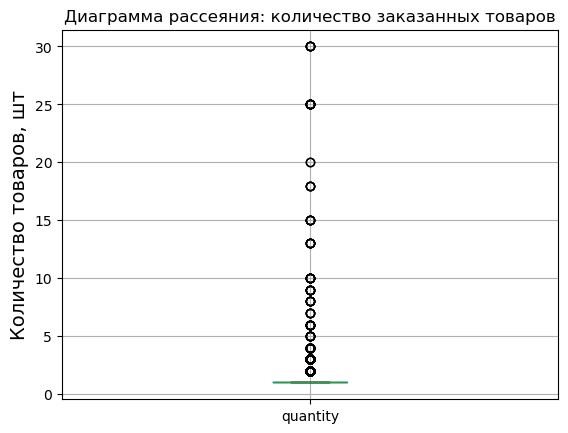

In [69]:
ax = pm.boxplot('quantity')
ax.set_title('Диаграмма рассеяния: количество заказанных товаров')
ax.set_ylabel('Количество товаров, шт', fontsize=14)
plt.show();

Видим, что крайне редко пользователи заказывают более 2 штук товаров. Выбросы тянутся до 30, сходя постепенно на нет. Несмотря на то, что это довольно редкое явление, сомневаться в их достоверности не приходится, и мы их пока не удаляем.

*Цена:*

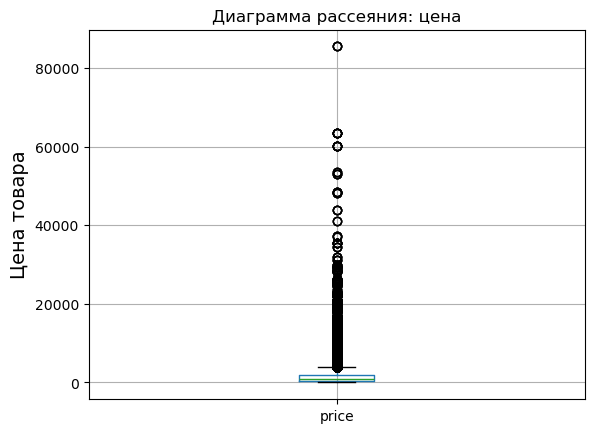

In [70]:
ax = pm.boxplot('price');
ax.set_title('Диаграмма рассеяния: цена')
ax.set_ylabel('Цена товара', fontsize=14)
plt.show()

Видим, что в редких случаях цена превышает 5000, выбросы постепенно сходят на нет в райне 40-60 тысяч (и есть одиночный выше 80).

In [71]:
pm[pm['price']>80000]

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta
502155,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711,14352.0,send,mobile_push,2023-12-22,2023-12-22 13:52:35,0,92,1 days 10:07:25
502156,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711,14352.0,open,mobile_push,2023-12-22,2023-12-22 13:53:17,0,92,1 days 10:06:43
502157,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711,14352.0,click,mobile_push,2023-12-22,2023-12-22 14:30:37,0,92,1 days 09:29:23
502158,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711,14352.0,purchase,mobile_push,2023-12-24,2023-12-24 07:47:01,0,92,-1 days +16:12:59


К сожалению, мы не можем проверить достоверность строки (например, по категориям товара), но и сомневаться в достоверности цены повода нет. Оставляем выброс. Интересно, что целевой признак - 0. То есть дорогостоящая покупка вовсе не означает, что клиент останется.

In [72]:
pm['price'].describe()

count    535950.000000
mean       1282.254740
std        1364.366873
min           1.000000
25%         419.000000
50%         999.000000
75%        1799.000000
max       85499.000000
Name: price, dtype: float64

*Суммарная стоимость (новый признак)*

In [73]:
#получим список самых эффективных с точки зрения таргета кампаний (опытным путем выяснили, что более ста таргетов - у первых 30 компаний
top_target = pm[pm['target']==1]['bulk_campaign_id'].value_counts().head(30).tolist()


In [74]:
#создадим новый признак - суммарная стоимость купленных пользователем товаров. Любопытно посмотреть на него в контексте возможной  
#мультколлинеарности других признаков. Возможно, он будет не слишком информативен - подавляющее большинство покупок состоит из одного товара.
pm['sum'] = pm['quantity']*pm['price']

In [75]:
#получим список самых эффективных кампаний с точки зрения суммы покупок (опытным путем выяснили, что сумма выше 20.000 - у первых 250 кампаний)
top_sum = pm.sort_values(by='sum', ascending=False)['bulk_campaign_id'].head(250).tolist()


In [76]:
#проверили, совпадают ли элементы в этих списках - не совпадают
common_elements = list(set(top_target) & set(top_sum))
common_elements

[]

*Рекламные кампании:*

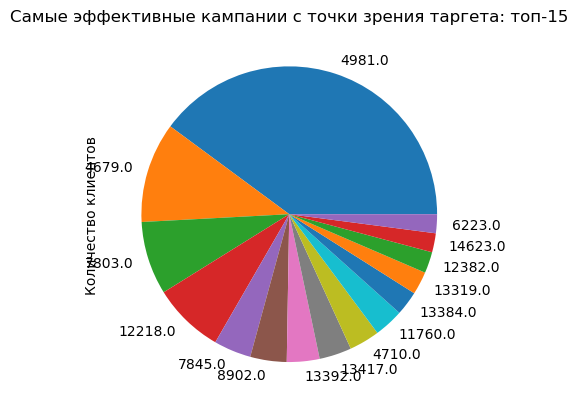

In [77]:
pm[pm['target']==1]['bulk_campaign_id'].value_counts().head(15).plot(kind='pie', \
    title='Самые эффективные кампании с точки зрения таргета: топ-15', label='Количество клиентов')
plt.yticks(rotation=45)
plt.show()


Мы посмотрели на распределение кампаний-лидеров по эффективности: есть определенные "гиганты", чья доля в таргете значительно выше других или по которым пользователи покупали товары на значительно более крупную сумму.

*Категории:*

In [78]:
pm['category_ids'].nunique()

933

Увидели, что из id категорий сложились 933 наименования, и среди них есть лидеры по количеству заказов - первые 100 наименований в рейтинге заказывают до 1000 раз, первые 10 - до 10.000 раз. Рискнем предположить, что категории 4 и 28 - самые популярные.

In [79]:
pm['category_ids'].value_counts().head(10)

category_ids
['4', '28', '57', '431']     28876
['4', '28', '244', '432']    21153
['4', '28', '260', '420']    19852
['2', '18', '258', '441']    14403
['4', '28', '275', '421']    13384
['4', '28', '124', '415']    12487
['4', '28', '62', '657']     11099
['4', '28', '275', '673']    10777
['4', '28', '62', '656']     10100
[]                            9654
Name: count, dtype: int64

In [80]:
pm.head(1)

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta,sum
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4679.0,click,email,2022-06-01,2023-07-05 14:34:01,0,10,-416 days +09:25:59,1999.0


*Кластеры:*

In [81]:
pivot = pm.pivot_table(index='cluster', values=['price', 'quantity'], aggfunc='mean')
pivot.sort_values(by='price', ascending=False)

,price,quantity
cluster,,
62,3508.855501,1.000000
53,3230.345384,1.000000
92,3147.234300,1.012681
45,3114.669943,1.001608
14,2900.819001,1.003380
...,...,...
67,129.990635,1.000520
89,129.210294,1.011765
66,62.868780,1.000000


In [82]:
pivot.sort_values(by='quantity', ascending=False)

,price,quantity
cluster,,
60,419.337754,1.089302
19,432.436242,1.046980
94,184.317037,1.042963
88,344.789914,1.031424
90,583.949781,1.029494
...,...,...
62,3508.855501,1.000000
64,1294.278481,1.000000
65,692.775083,1.000000


In [83]:
pivot2 = pm.pivot_table(index='cluster', values= 'target', aggfunc='mean')

In [84]:
pivot2.sort_values(by='target', ascending=False).head(10)

,target
cluster,
42,0.162272
62,0.088670
29,0.085967
67,0.082726
64,0.072497
99,0.067588
10,0.066214
26,0.065859
49,0.061568


Видим кластеры-лидеры по целевому признаку.

*Канал рассылки и действие пользователя:*

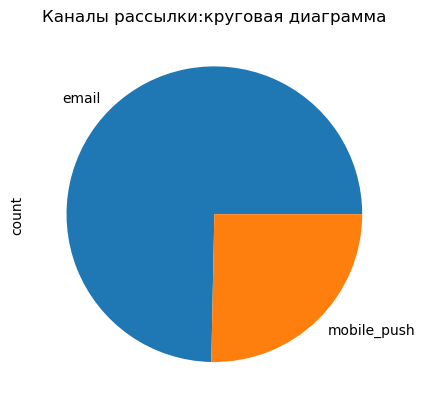

In [85]:
pm['channel'].value_counts().plot(kind='pie')
plt.title('Каналы рассылки:круговая диаграмма')
plt.show();

Видим, что 3/4 случаев - это почтовая рассылка.

In [86]:
pm['event'].value_counts()

event
click          206002
purchase       145190
send            94878
open            89530
hard_bounce       248
unsubscribe        69
complain           26
subscribe           7
Name: count, dtype: int64

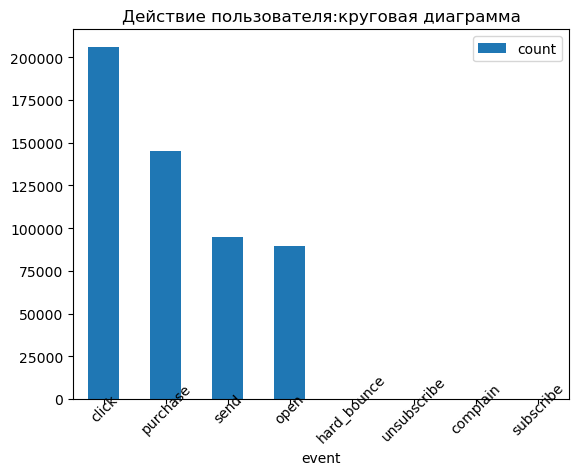

In [87]:
pm['event'].value_counts().plot(kind='bar')
plt.title('Действие пользователя:круговая диаграмма')
for label in plt.gca().get_xticklabels():
    label.set_rotation(45)
    label.set_ha('center')
    label.set_va('center')
plt.legend(loc='upper right')

plt.show();

Видим, что чаще всего пользователи кликают на сообщение и совершают покупку.

In [88]:
pm[pm['event']=='hard_bounce']['target'].value_counts()[1] / pm[pm['event']=='hard_bounce']['target'].value_counts()[0]

0.06896551724137931

In [89]:
len(pm[pm['target']==1])/len(pm)

0.037441925552756786

Можно было бы рекомендовать отдельно поработать с категорией покупателей, у которых в действиях стоит hard bounce. Однако мы видим, что даже в этой категории пользователи совершают целевое действие, и этот процент покупателей даже выше, чем по всему датасету.

*Временная дельта между созданием сообщения и покупкой*

In [90]:
pm['delta'].describe()

count                         535950
mean     -4 days +15:33:06.618326337
std       53 days 06:33:14.017245001
min              -639 days +15:06:47
25%                -1 days +09:17:06
50%                -1 days +14:34:01
75%                  0 days 06:39:04
max                552 days 16:25:59
Name: delta, dtype: object

Видим, что дельта между созданием маркетингового сообщения и покупкой составляет несколько лет - как в одну, так и в другую сторону. Чаще всего по датасету пользователь покупал товар за 4 дня до получения сообщения.

У нас появилось опасение, что может присутствовать ошибка выжившего на границе даты создания сообщений. Например, самая поздняя дата создания сообщения - 15 февраля 2024. По интересному стечению обстоятельств засчитаны только те объекты датафрейма, у которых таргет 1. Остальные (купили они или не купили в течение 90 дней - и то и то показательный результат) - не засчитаны вообще! Дельта всех покупок, совершенных по этому сообщению - менее суток. Достоверно ли обучать модель на таких выборочных данных?

Возможно, в процессе работы стоит попробовать отбросить последние 90 дней из pm['created_at'].

In [91]:
pm[pm['created_at']==pm['created_at'].max()]

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta,sum
535921,1515915626009802894,1,280.0,"['5562', '5630', '5669', '606']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,52,0 days 00:08:40,280.0
535924,1515915626009802894,1,419.0,"['5562', '5630', '5607', '555']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,41,0 days 00:08:40,419.0
535927,1515915626009802894,1,599.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,11,0 days 00:08:40,599.0
535930,1515915626009802894,1,461.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,11,0 days 00:08:40,461.0
535933,1515915626009802894,1,999.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,11,0 days 00:08:40,999.0
535936,1515915626009802894,1,768.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,11,0 days 00:08:40,768.0
535939,1515915626009802894,1,999.0,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,24,0 days 00:08:40,999.0
535942,1515915626009802894,1,769.0,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c,14633.0,click,mobile_push,2024-02-15,2024-02-15 23:51:20,1,24,0 days 00:08:40,769.0


In [92]:
pm[pm['created_at']==pm['created_at'].min()]

,client_id,quantity,price,category_ids,date_p,message_id,bulk_campaign_id,event,channel,date_m,created_at,target,cluster,delta,sum
595,1515915625498693110,1,1499.0,"['4', '28', '58', '434']",2022-05-18,1515915625498693110-4439-62834130c8234,4439.0,click,email,2022-05-19,2022-05-19 01:50:17,0,30,-2 days +22:09:43,1499.0
999,1515915625498693110,1,999.0,"['4', '28', '275', '421']",2022-05-19,1515915625498693110-4439-62834130c8234,4439.0,click,email,2022-05-19,2022-05-19 01:50:17,0,24,-1 days +22:09:43,999.0


*Сумма покупки:*

In [93]:
pm['sum'].describe()

count    535950.000000
mean       1293.764262
std        1389.193678
min           1.000000
25%         419.000000
50%         999.000000
75%        1799.000000
max       85499.000000
Name: sum, dtype: float64

Видим, что в подавляющем большинстве случаев (75%) сумма покупки не превышает 2000 рублей.

Рассмотрим особенности покупателей, которые совершают целевое действие - покупку в течение 90 дней.

In [94]:
pm[pm['target']==1] ['event'].value_counts()/len(pm[pm['target']==1])

event
click          0.403149
purchase       0.281557
open           0.159266
send           0.155230
hard_bounce    0.000797
Name: count, dtype: float64

In [95]:
pm[pm['target']==1] ['channel'].value_counts()/len(pm[pm['target']==1])

channel
email          0.71356
mobile_push    0.28644
Name: count, dtype: float64

In [96]:
pm[pm['target']==1] ['delta'].mean()

Timedelta('-2 days +00:27:32.000348832')

In [97]:
pm[pm['target']==1] ['cluster'].mode()

0    22
Name: cluster, dtype: int32

In [98]:
pm[pm['target']==0]['event'].value_counts()/len(pm[pm['target']==0])

event
click          0.383637
purchase       0.270488
send           0.177876
open           0.167352
hard_bounce    0.000450
unsubscribe    0.000134
complain       0.000050
subscribe      0.000014
Name: count, dtype: float64

In [99]:
pm[pm['target']==0] ['channel'].value_counts()/len(pm[pm['target']==0])

channel
email          0.747993
mobile_push    0.252007
Name: count, dtype: float64

In [100]:
pm[pm['target']==0] ['delta'].mean()

Timedelta('-4 days +14:16:18.509857856')

In [101]:
pm[pm['target']==0] ['cluster'].mode()

0    22
Name: cluster, dtype: int32

Видим, что значимых очевидных отличий между клиентами с таргетом 1 и с таргетом 0 не наблюдается.
В попытке найти закономерность создадим еще один признак - сумма всех покупок клиента.

In [102]:
total = pm.pivot_table(index='client_id', values='sum', aggfunc='sum')
pm = pd.merge(pm, total, how='left', on='client_id')

In [103]:
pm = pm.rename(columns={'sum_x':'sum_p', 'sum_y': 'sum_total'})

In [104]:
pm[pm['target']==0] ['sum_total'].mean()

63539.80231564134

In [105]:
pm[pm['target']==1] ['sum_total'].mean()

371884.551751632

Сумма покупок за все время отличается у клиентов с разным целевым признаком почти в 6 раз.

*Промежуточный вывод:*

* Мы создали четыре новых признака (временная дельта, кластер по категориям, сумма покупки и сумма всех покупок). По сумме всех покупок есть заметное различие между клиентами с таргетом 1 и с таргетом 0.

* Видим, что в подавляющем большинстве случаев (75%) сумма покупки не превышает 2000 рублей.

* Видим, что дельта между созданием маркетингового сообщения и покупкой составляет несколько лет - как в одну, так и в другую сторону. Чаще всего по датасету пользователь покупал товар за 4 дня до получения сообщения.

* Есть опасение, что может присутствовать ошибка выжившего на границе даты создания сообщений. Например, самая поздняя дата создания сообщения - 15 февраля 2024. По интересному стечению обстоятельств засчитаны только те объекты датафрейма, у которых таргет 1. Остальные (купили они или не купили в течение 90 дней - и то и то показательный результат) - не засчитаны вообще.

Возможно, в процессе работы стоит попробовать отбросить последние 90 дней из pm['created_at'].

## 4. Корреляционный анализ.

Для корреляционного анализа оставляем признаки, не являющиеся ключами или идентификаторами.

In [106]:
data = pm[['quantity', 'price', 'date_p', 'event', 'channel', 'date_m', 'created_at', 'target', 'cluster', 'delta', 'sum_p', 'sum_total']]

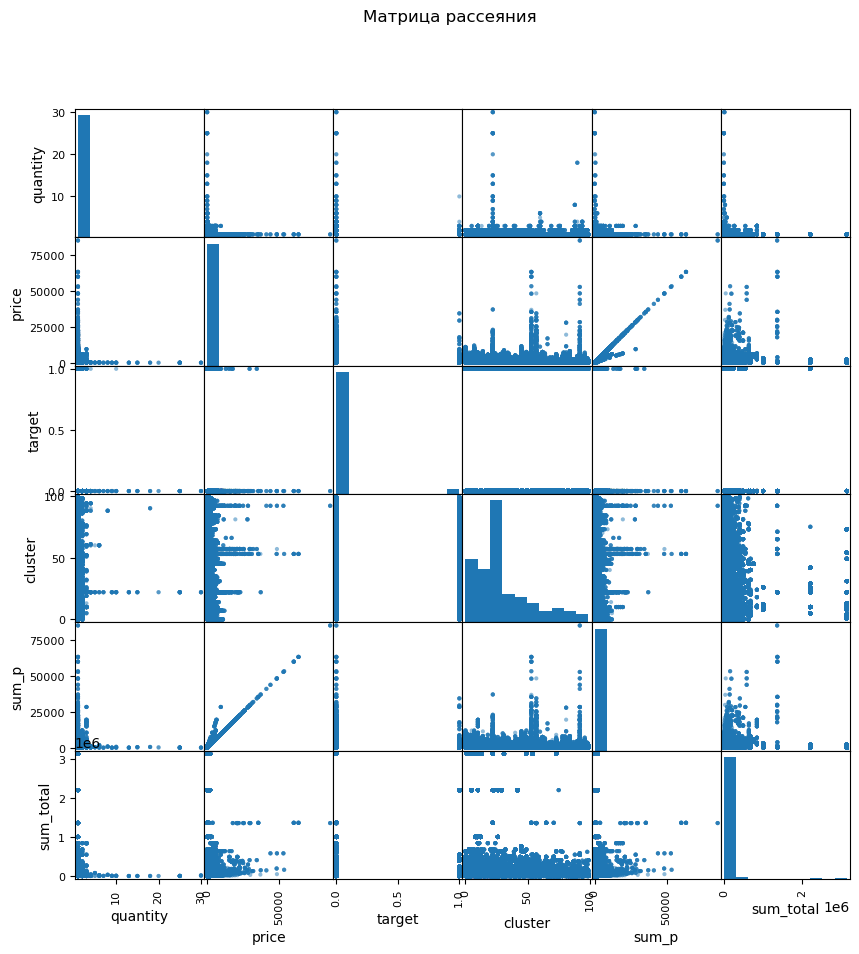

In [107]:
pd.plotting.scatter_matrix(data, figsize=(10,10))
plt.suptitle('Матрица рассеяния')
plt.show();

Увидели взаимосвязь между суммой покупки и ценой товара. Приняли решение, что сумму покупки можно убрать, если оставить сумму всех покупок пользователя (sum_total) во избежание мультиколлинеарности.

In [108]:
data_m = pm[['quantity', 'price', 'event', 'channel','target', 'cluster', 'delta', 'sum_total']]

In [109]:
data_m['delta'] = data_m['delta'].astype(int)

/var/folders/89/jgt678_s0ljdwtt51jbf1cvm0000gn/T/ipykernel_2220/585162129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m['delta'] = data_m['delta'].astype(int)


*Промежуточный итог:*

Мы оставили исходные признаки и некоторые добавленные (дельта времени, сумма всех покупок пользователя) и убрали признаки-ключи к другим таблицам.

## 5. Создание модели

В поиске самой эффективной модели мы будем использовать пайплайн.

Для кодирования категориальный признаков используем OneHotEncoder.

Для масштабирования используем StandardScaler, MinMaxScaler, RobustScaler.

Выбираем из следующий моделей: 
* модель, основанная на опорных векторах
* древесная
* модель на основе k ближайших соседей
* логистическая регрессия.

In [110]:
ohe_columns = ['event', 'channel']
num_columns = ['quantity', 'price', 'sum_total','cluster', 'delta']

In [111]:

X = data_m.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=TEST_SIZE,
                                                   stratify=y)

ohe_pipe = Pipeline(
    [
        ('simpleimputer_ohe',
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe',
         OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)
             

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder = 'passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVR(kernel='rbf', degree=3)),

    ]
)

param_grid = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,20),
     'models__max_features': range(1,20),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {'models': [LogisticRegression(
        random_state = RANDOM_STATE,
        solver='liblinear',
        penalty='l2')],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {'models': [SVC(
        probability=True,
        random_state=RANDOM_STATE)],
     'models__kernel': ['linear', 'sigmoid', 'rbf', 'poly'],
     'models__degree': range(2,4),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleimputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['event',
                                                                                'channel']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['quantity',
                                                                                'price',
                                                                                'sum_total',
                                                                                'clu...
                                                                       solver='liblinear')],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 4),
                                         'models__kernel': ['linear', 'sigmoid',
                                                            'rbf', 'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [112]:
result = pd.DataFrame(randomized_search.cv_results_)
print('Лучшие модели для решения задачи:',\
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')) 

Лучшие модели для решения задачи:    rank_test_score                             param_models  mean_test_score  \
0                1  DecisionTreeClassifier(random_state=42)         0.852263   
3                1  DecisionTreeClassifier(random_state=42)         0.852263   
5                3  DecisionTreeClassifier(random_state=42)         0.840136   
4                4  DecisionTreeClassifier(random_state=42)         0.837363   
8                5  DecisionTreeClassifier(random_state=42)         0.832763   
1                6  DecisionTreeClassifier(random_state=42)         0.792515   
2                7  DecisionTreeClassifier(random_state=42)         0.749632   
7                8  DecisionTreeClassifier(random_state=42)         0.687342   
9                9  DecisionTreeClassifier(random_state=42)         0.686639   
6               10  DecisionTreeClassifier(random_state=42)         0.683852   

                                              params  
0  {'preprocessor__num': Robus

In [113]:
print('ROC-AUC лучшей модели  на тренировочных данных:', round(randomized_search.best_score_, 2))

ROC-AUC лучшей модели  на тренировочных данных: 0.85


In [114]:
y_proba = randomized_search.best_estimator_.predict_proba(X_test)

In [115]:
print('ROC-AUC лучшей модели  на тестовых данных:', round(roc_auc_score(y_test, y_proba[:,1]), 2))


ROC-AUC лучшей модели  на тестовых данных: 0.85


Мы получили значение целевой метрики 0.85.

Однако нам предстоит решить, ошибка какого рода является более критичной в данном проекте:

* ошибка второго рода (не пропускаем ли мы клиента, готового совершить покупку) - метрика recall в таком случае для нас более важна
* ошибка первого рода (не слишком ли часто мы ложно ожидаем, что клиент совершит покупку) - метрика precision будет приоритетной.
* как гармоническое среднее можем использовать f1 score, чтобы учесть ложноположительные и ложноотрицательные ответы.


На наш взгляд, в данном проекте задача - спрогнозировать отток покупателей и предотвратить его, а значит, нужно сконцентрироваться на ошибке второго рода и метрике precision (или f1score, как вариант).

In [116]:
y_pred = randomized_search.best_estimator_.predict(X_test)

In [117]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[128835    136]
 [  2859   2158]]


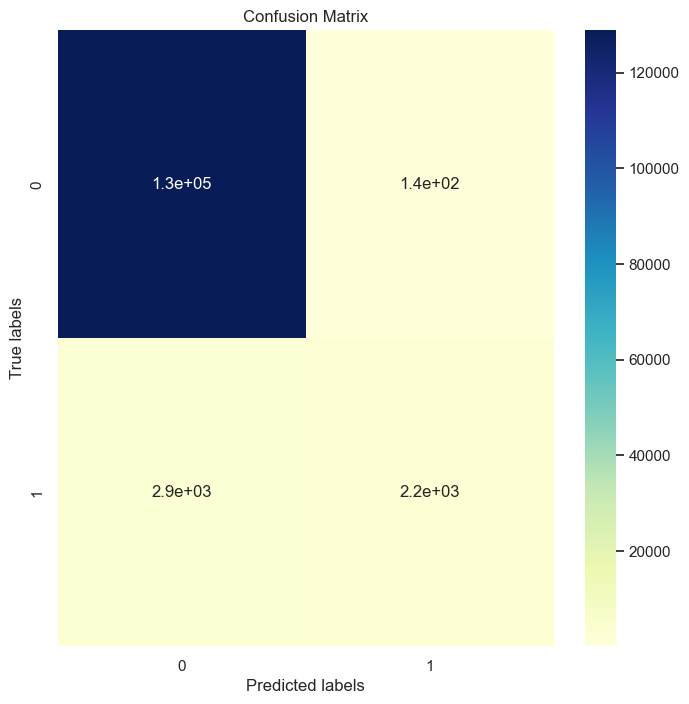

In [118]:
sns.set()
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [119]:
accuracy = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0])
precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
recall = cm[0, 0] / (cm[0, 0] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall,2))
print("F1-score:", round(f1_score,2))


Accuracy: 0.98
Precision: 1.0
Recall: 0.98
F1-score: 0.99


*Промежуточный вывод:* 
Из использованных моделей лучше всех показало себя дерево решений с глубиной 16 и скейлером RobustScaler.

Целевая метрика на тестовых данных составила 0.85, в то время как самая важная для данного проекта метрика precision составила 0.99 (если не округлять до 2 знаков).


## Выводы.

* Мы загрузили три обязательных для работы датафрейма и два дополнительных, решили проблему дубликатов и категоризации/кластеризации товаров.

* Мы создали четыре новых признака (временная дельта, кластер по категориям, сумма покупки и сумма всех покупок). 

* Из использованных моделей лучше всех показало себя дерево решений с глубиной 16 и скейлером RobustScaler.

* Целевая метрика на тестовых данных составила 0.85, в то время как самая важная для данного проекта метрика precision составила 0.99 (если не округлять до 2 знаков). Таким образом, модель не слишком часто дает ложноположительные ответы в прогнозировании неактивных в будущем покупателей.

* Если возникнет потребность изменить модель или продолжить работу над проектом, мы готовы предложить отбросить последние 90 дней из pm['created_at'], потому что есть опасение, что может присутствовать ошибка выжившего на границе даты создания сообщений. Например, самая поздняя дата создания сообщения - 15 февраля 2024. По интересному стечению обстоятельств засчитаны только те объекты датафрейма, у которых таргет 1. Остальные (купили они или не купили в течение 90 дней - и то и то показательный результат) - не засчитаны вообще.

* Можно также более категорично отнестись к выбросам по верхней границе.

* Кроме того, в работе пока что не были использованы бустинги.

In [120]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
